Imports

In [107]:
import os
import sys
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import Counter
from scipy.stats import percentileofscore

sys.path.insert(0, "..")
from utils import join_data, load_dataset
from utils import preprocess, get_sequence, generate_sampling_data, load_single_dataset
from utils import RESULTSPATH, SEGMENTS, SEGMENT_DICTS, ACCNUMDICT
plt.style.use("seaborn")

Load data

In [2]:
dfs = list()
dfnames = ["Alnaji2021", "Pelz2021", "Wang2023", "Wang2020", "Zhuravlev2020", "Kupke2020", "VdHoecke2015"]
strain = "PR8"
for dataset in dfnames:
    df = join_data(load_dataset(dataset))
    dfs.append(preprocess(strain, df, 1))

In [9]:
for df, dfname in zip(dfs, dfnames):
    print(dfname)
    print(f"\t{df.shape}")

Alnaji2021
	(25662, 11)
Pelz2021
	(33595, 11)
Wang2023
	(30976, 11)
Wang2020
	(4988, 11)
Zhuravlev2020
	(3720, 11)
Kupke2020
	(1133, 11)
VdHoecke2015
	(7164, 11)


Generate overlapping candidates matrix plot

/tmp/ipykernel_53748/1565716762.py:32: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(fraction=0.046, pad=0.04, label="Intersecting DelVGs [%]")


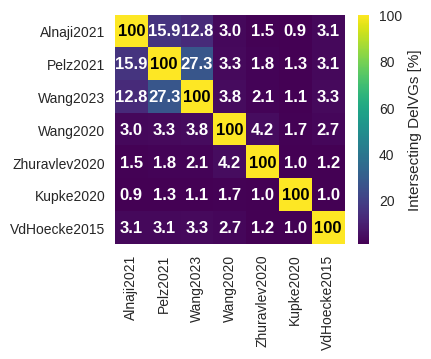

In [90]:
def generate_overlap_matrix_plot(dfs: list, dfnames: list, name: str=""):
    '''
        plot a matrix that shows how big the overlap of DelVGs between the
        given datasets is.
        :param dfs: The list of DataFrames containing the data, preprocessed
            with sequence_df(df)
        :param dfnames: The names associated with each DataFrame in `dfs`
        :param name: string to define result and name of resultsfile

        :return: None
    '''
    plt.figure(figsize=(5, 4))
    plt.rc("font", size=20)
    # initialize an empty matrix
    matrix_size = len(dfs)
    matrix = [[0] * matrix_size for _ in range(matrix_size)]
    # calculate the differences and populate the matrix
    for i in range(matrix_size):
        set1 = set(dfs[i]["key"])
        for j in range(matrix_size):
            set2 = set(dfs[j]["key"])
            matrix[i][j] = len(set1 & set2) / (max(len(set1), len(set2), 1)) * 100
            if i == j:
                text = f"{matrix[i][j]:.0f}"
                color = "black"
            else:
                text = f"{matrix[i][j]:.1f}"
                color = "white"
            plt.annotate(text, xy=(j, i), color=color, ha='center', va='center', fontsize=12, fontweight='bold')

    plt.imshow(matrix, cmap="viridis", interpolation="nearest")
    plt.colorbar(fraction=0.046, pad=0.04, label="Intersecting DelVGs [%]")
    plt.xticks(np.arange(len(dfnames)), dfnames, rotation=90)
    plt.yticks(np.arange(len(dfnames)), dfnames)
    plt.tight_layout()
    plt.grid(False)

    if name != "":
        filename = f"{name}_intersection_matrix_PR8.png"
    else:
        filename = "intersection_matrix_PR8.png"
    save_path = os.path.join(RESULTSPATH, "intersection_analysis")
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    plt.savefig(os.path.join(save_path, filename))
    plt.show()
    plt.close()

generate_overlap_matrix_plot(dfs, dfnames)

Get max overlapping candidates

   Segment  no.datasets  count
0       HA            4     33
1       HA            5     10
2       HA            6      1
3        M            4      9
4       NA            4     11
5       NA            5      2
6       NP            4     35
7       NP            5      8
8       NS            4      2
9       PA            4    258
10      PA            5     48
11      PA            6      8
12      PA            7      3
13     PB1            4    258
14     PB1            5     54
15     PB1            6     10
16     PB1            7      2
17     PB2            4    157
18     PB2            5     33
19     PB2            6      2
   Segment  no.datasets  count
0       HA            4     33
1       HA            5     10
2       HA            6      1
3        M            4      9
4       NA            4     11
5       NA            5      2
6       NP            4     35
7       NP            5      8
8       NS            4      2
9       PA            4    258
10      

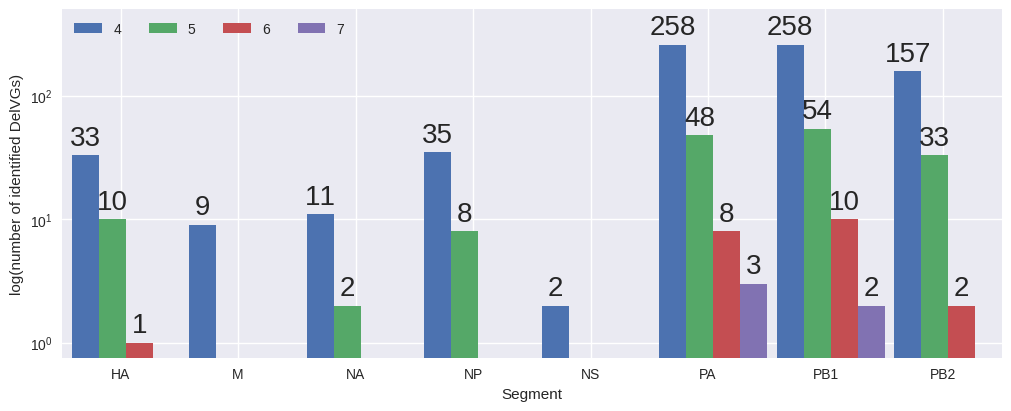

In [135]:
def generate_max_overlap_candidates(dfs: list)-> pd.DataFrame:
    '''
        analyses for all DelVGs in the given datasets how often they occur in
        the datasets and resturns this in a DataFrame.
        :param dfs: The list of DataFrames containing the data, preprocessed
            with sequence_df(df)
        :param thresh: threshold for occurrence of a DelVG to be considered

        :return: DataFrame with all DelVGs above or equal to given threshold
    '''
    all_candidates = list()
    for df in dfs:
        all_candidates.extend(df["key"].tolist())
    candidate_counts = Counter(all_candidates)
    # at least half of the datasets (7)
    thresh = 4
    candidates = list()
    counts = list()
    for cand, count in candidate_counts.items():
        if count >= thresh:
            candidates.append(cand)
            counts.append(count)
            
    count_df = pd.DataFrame(dict({"DI": candidates, "no.datasets": counts}))
    count_df[["Segment", "Start", "End"]] = count_df["DI"].str.split("_", expand=True)
    count_table = count_df.groupby(["Segment", "no.datasets"]).size().reset_index(name='count')
    print(count_table)
    return count_df

def barplot_counts(count_df):
    count_table = count_df.groupby(["Segment", "no.datasets"]).size().reset_index(name='count')
    print(count_table)
    zero_df = pd.DataFrame({"Segment": ["HA", "M", "M", "M", "NA", "NA", "NP", "NP", "NS", "NS", "NS", "PB2"],
                            "no.datasets": [7, 5, 6, 7, 6, 7, 6, 7, 5, 6, 7, 7],
                            "count": [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]})
    comb_df = pd.concat([count_table, zero_df])
    comb_df = comb_df.sort_values(by=['Segment', 'no.datasets'])

    x = np.arange(8)
    width = 0.23
    multiplier = 0
    fig, ax = plt.subplots(layout='constrained', figsize=(10, 4))

    for i in [4, 5, 6, 7]:
        data = comb_df[comb_df['no.datasets'] == i]['count'].to_list()
        offset = width * multiplier - 0.3
        rects = ax.bar(x + offset, data, width, label=f'{i}')
        ax.bar_label(rects, padding=3)
        multiplier += 1
    
    ax.set_xticks(x, comb_df['Segment'].unique())
    ax.set_yscale('log')
    ax.set_ylim(top=500)
    ax.set_xlim(left=-0.5, right=7.5)
    ax.set_xlabel('Segment')
    ax.set_ylabel('log(number of identified DelVGs)')
    plt.legend(loc='upper left', ncol=4)

    filename = "candidate_counts_bar.png"
    save_path = os.path.join(RESULTSPATH, "intersection_analysis")
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    plt.savefig(os.path.join(save_path, filename))
    plt.show()
    plt.close()

count_df = generate_max_overlap_candidates(dfs)
barplot_counts(count_df)

Calculate pelz labels for each candidate and percentiles

In [136]:
count_df = count_df[count_df['Segment'].isin(['PA', 'PB1', 'PB2'])]

def assign_label(row):
    '''
    
    '''
    start = row["VB3-Saat"]
    end = row["VB3-48"]
    t1 = "de novo " if start == 0 else ""
    t2 = "gain" if start < end else "loss"
    return f"{t1}{t2}"

for accnum in ACCNUMDICT["Pelz2021"].keys():
    t_df = load_single_dataset("Pelz2021", accnum, SEGMENT_DICTS["PR8"])
    t_df["DI"] = t_df["Segment"] + "_" + t_df["Start"].map(str) + "_" + t_df["End"].map(str)
    if accnum == "SRR15084925":
        t_df = t_df.rename(columns={'NGS_read_count': "VB3-Saat"})
        pelz_data = t_df
    elif accnum == "SRR15084909":
        t_df = t_df.rename(columns={'NGS_read_count': "VB3-48"})
        pelz_data = pd.merge(pelz_data, t_df[['DI', 'VB3-48']], on='DI', how='outer')
    else:
        pelz_data = pd.merge(pelz_data, t_df['DI'], on='DI', how='outer')

drop = ['Segment', 'Start', 'End']
pelz_data = pelz_data.drop(columns=drop)
pelz_data = pelz_data.fillna(0)
pelz_data['label'] = pelz_data.apply(assign_label, axis=1)
count_df = pd.merge(count_df, pelz_data[['DI', 'label']], on='DI', how='left')

for df, dfname in zip(dfs, dfnames):
    perc_list = list()
    for c in count_df['DI'].to_list():
        ngs_count = df[df["key"] == c]["NGS_read_count"]
        if ngs_count.empty:
            percentile = 0.0
        else:
            percentile = percentileofscore(df["NGS_read_count"], ngs_count.values[0])

        perc_list.append(percentile)

    count_df[dfname] = perc_list

Use the highest occuring candidates to define filter criteria

In [132]:
def define_filters(dfs: list, count_df: pd.DataFrame, segment: str)-> None:
    '''
       
    '''
    n = 6 if segment == 'PB2' else 7
    selected = count_df[(count_df['no.datasets'] == n) & (count_df['Segment'] == segment)]

    cands = selected['DI'].to_list()
    data = list()
    for c in cands:
        percentiles = list()
        for df in dfs:
            if c not in df["key"].tolist():
                percentiles.append(0.0)
            else:
                ngs_count = df[df["key"] == c]["NGS_read_count"].values[0]
                percentile = percentileofscore(df["NGS_read_count"], ngs_count)
                percentiles.append(percentile)

        percentiles.sort(reverse=True)
        data.append(percentiles)

    df = pd.DataFrame({c: v for c, v in zip(cands, data)}).T
    return df

def test_filters(filter_df, count_df, segment):
    '''

    '''
    count_df = count_df[count_df['Segment'] == segment]   
    for i, column in enumerate(filter_df.columns):
        min_value = math.floor(round(filter_df[column].min(), 1))
        
        final_cands = list()
        for _, r in count_df.iterrows():
            counter = 0
            for v in r[6:].to_list():
                if v >= min_value:
                    counter += 1
            if counter >= 1+i:
                final_cands.append(r['DI'])
        print(f"{i+1}\t{min_value}\t{len(final_cands)}")

        if i+1 == 5:
            r_cands = final_cands
    
    return r_cands

print(count_df)

print('PA')
filter_df = define_filters(dfs, count_df, 'PA')
_ = test_filters(filter_df, count_df, 'PA')
print('PB1')
filter_df = define_filters(dfs, count_df, 'PB1')
_ = test_filters(filter_df, count_df, 'PB1')
print('PB2')
filter_df = define_filters(dfs, count_df, 'PB2')
pb2_cands = test_filters(filter_df, count_df, 'PB2')

               DI  no.datasets Segment Start   End         label  Alnaji2021  \
0       PA_84_139            4      PA    84   139          loss   92.650612   
1      PA_84_1990            4      PA    84  1990          loss   17.613592   
2      PA_84_2042            4      PA    84  2042          gain   87.575014   
3      PA_84_2063            4      PA    84  2063          loss   94.458733   
4      PA_85_2012            4      PA    85  2012          loss   87.575014   
..            ...          ...     ...   ...   ...           ...         ...   
828  PB2_449_1759            4     PB2   449  1759  de novo loss    0.000000   
829  PB2_467_1759            4     PB2   467  1759  de novo loss    0.000000   
830  PB2_468_1793            5     PB2   468  1793          loss    0.000000   
831  PB2_480_1792            4     PB2   480  1792  de novo loss    0.000000   
832  PB2_320_1948            4     PB2   320  1948           NaN    0.000000   

      Pelz2021   Wang2023   Wang2020  Z

## Elaborate PB2 candidates


In [133]:
def score_sum(row):
    s = row.iloc[6:13].sum()
    return s
def score_mean(row):
    s = row.iloc[6:13].mean()
    return s

res_df = count_df[count_df['DI'].isin(pb2_cands)]
res_df['score_sum'] = res_df.apply(score_sum, axis=1)
res_df['score_mean'] = res_df.apply(score_mean, axis=1)
print(res_df.sort_values(by='score_sum', ascending=False)['DI'].to_list())
print(res_df.sort_values(by='score_mean', ascending=False)['DI'].to_list())

sort_df = res_df.sort_values(by='score_sum', ascending=False)
print(sort_df)
filename = "pb2_candidates.csv"
save_path = os.path.join(RESULTSPATH, "intersection_analysis")
if not os.path.exists(save_path):
    os.makedirs(save_path)
sort_df.to_csv(os.path.join(save_path, filename), index=False)

['PB2_163_2152', 'PB2_109_2152', 'PB2_191_2048', 'PB2_163_2139', 'PB2_177_2141', 'PB2_258_2003', 'PB2_179_2138', 'PB2_217_1976', 'PB2_191_2053', 'PB2_143_2139', 'PB2_216_1969', 'PB2_112_2142', 'PB2_163_2053', 'PB2_223_2037', 'PB2_183_2048', 'PB2_191_2003', 'PB2_259_1994', 'PB2_246_2172', 'PB2_120_2140', 'PB2_199_2152']
['PB2_163_2152', 'PB2_109_2152', 'PB2_191_2048', 'PB2_163_2139', 'PB2_177_2141', 'PB2_258_2003', 'PB2_179_2138', 'PB2_217_1976', 'PB2_191_2053', 'PB2_143_2139', 'PB2_216_1969', 'PB2_112_2142', 'PB2_163_2053', 'PB2_223_2037', 'PB2_183_2048', 'PB2_191_2003', 'PB2_259_1994', 'PB2_246_2172', 'PB2_120_2140', 'PB2_199_2152']
               DI  no.datasets Segment Start   End         label  Alnaji2021  \
570  PB2_163_2152            6     PB2   163  2152  de novo gain   99.101785   
520  PB2_109_2152            5     PB2   109  2152          gain   99.643442   
603  PB2_191_2048            5     PB2   191  2048  de novo gain   90.760658   
569  PB2_163_2139            5     PB2

/tmp/ipykernel_53748/3340834650.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_df['score_sum'] = res_df.apply(score_sum, axis=1)
/tmp/ipykernel_53748/3340834650.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_df['score_mean'] = res_df.apply(score_mean, axis=1)


Just use score to classify them

In [141]:
res_df = count_df[count_df['Segment'].isin(['PB2'])]
res_df['score_sum'] = res_df.apply(score_sum, axis=1)
res_df['score_mean'] = res_df.apply(score_mean, axis=1)
print(res_df.sort_values(by='score_sum', ascending=False)['DI'].to_list())
print(res_df.sort_values(by='score_mean', ascending=False)['DI'].to_list())

sort_df = res_df.sort_values(by='score_sum', ascending=False)
print(sort_df)
filename = "test_pb2_candidates.csv"
save_path = os.path.join(RESULTSPATH, "intersection_analysis")
if not os.path.exists(save_path):
    os.makedirs(save_path)
sort_df.to_csv(os.path.join(save_path, filename), index=False)

['PB2_163_2152', 'PB2_109_2152', 'PB2_191_2048', 'PB2_163_2139', 'PB2_177_2141', 'PB2_258_2003', 'PB2_179_2138', 'PB2_217_1976', 'PB2_191_2053', 'PB2_143_2139', 'PB2_216_1969', 'PB2_108_2140', 'PB2_112_2142', 'PB2_163_2053', 'PB2_223_2037', 'PB2_183_2048', 'PB2_191_2003', 'PB2_216_2139', 'PB2_259_1994', 'PB2_246_2172', 'PB2_120_2140', 'PB2_199_2152', 'PB2_191_2195', 'PB2_212_2136', 'PB2_218_2005', 'PB2_215_2068', 'PB2_258_1975', 'PB2_163_2159', 'PB2_192_2140', 'PB2_163_192', 'PB2_121_2139', 'PB2_139_1961', 'PB2_159_2152', 'PB2_156_2139', 'PB2_191_2152', 'PB2_90_133', 'PB2_164_2066', 'PB2_468_1793', 'PB2_128_2156', 'PB2_217_2007', 'PB2_215_2206', 'PB2_225_2096', 'PB2_217_1983', 'PB2_127_2140', 'PB2_191_1975', 'PB2_216_2067', 'PB2_163_2123', 'PB2_226_2070', 'PB2_161_2151', 'PB2_224_2002', 'PB2_163_2006', 'PB2_118_2004', 'PB2_190_2100', 'PB2_258_2053', 'PB2_215_2080', 'PB2_190_2056', 'PB2_177_2042', 'PB2_128_2152', 'PB2_152_2152', 'PB2_118_2153', 'PB2_116_2140', 'PB2_159_2065', 'PB2_128_2

/tmp/ipykernel_53748/1871408941.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_df['score_sum'] = res_df.apply(score_sum, axis=1)
/tmp/ipykernel_53748/1871408941.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_df['score_mean'] = res_df.apply(score_mean, axis=1)


## validation with random data

/tmp/ipykernel_53748/1565716762.py:32: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(fraction=0.046, pad=0.04, label="Intersecting DelVGs [%]")


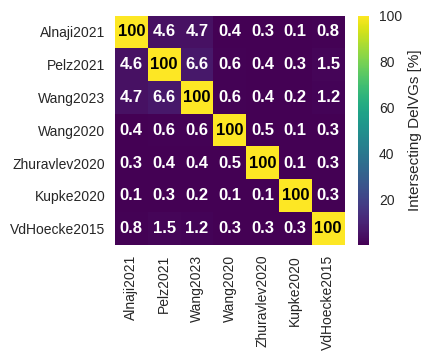

  Segment  no.datasets  count
0      PA            4     53
1      PA            5      4
2     PB1            4     58
3     PB1            5      7
4     PB1            6      2
5     PB2            4      6


In [16]:
rounds = 1
for i in range(rounds):
    sampl_dfs = list()
    for df in dfs:
        for seg in SEGMENTS:
            s_df = df.loc[df["Segment"] == seg]
            n = s_df.shape[0]
            if n == 0:
                continue
            seq = get_sequence(strain, seg)
            start = int(s_df["Start"].mean())
            end = int(s_df["End"].mean())
            s = (max(start-200, 50), start+200)
            e = (end-200, min(end+200, len(seq)-50))
            
            if not (s[1] < e[0]):
                continue
            #skip if there is no range given
            #this would lead to oversampling of a single position
            if s[0] == s[1] or e[0] == e[1]:
                continue
            if "samp_df" in locals():
                temp_df = generate_sampling_data(seq, s, e, n)
                temp_df["Segment"] = seg
                samp_df = pd.concat([samp_df, temp_df], ignore_index=True)
            else:
                samp_df = generate_sampling_data(seq, s, e, n)
                samp_df["Segment"] = seg
        samp_df["NGS_read_count"] = 1
        sampl_dfs.append(preprocess(strain, samp_df, 1))
        del samp_df
    generate_overlap_matrix_plot(sampl_dfs, dfnames, name="testing")
    count_df = generate_max_overlap_candidates(sampl_dfs)